In [1]:
def timestamp():
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))

## Parameters

In [2]:
prefix='./results/'
n_jobs = 10
n_trees = 10

## Imports

In [3]:
%run ___imports.ipynb 
from metrics import *

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Loading

In [4]:
with open('simplified_reccurent_CD_pt1.pkl', "rb") as fh:
            df1 = pickle.load(fh)
with open('simplified_reccurent_CD_pt2.pkl', "rb") as fh:
            df2 = pickle.load(fh)        
with open('simplified_reccurent_CD_pt3.pkl', "rb") as fh:
            df3 = pickle.load(fh)       
with open('simplified_reccurent_CD_pt4.pkl', "rb") as fh:
            df4 = pickle.load(fh)

df = pd.concat([df1,df2,df3,df4])

df.TX_DATETIME = (df.TX_DATETIME - datetime.strptime('2018-04-01', '%Y-%m-%d')).dt.days

train = df[df['TX_DATETIME']>=0]
train = train[train['TX_DATETIME']<7]
test = df[df['TX_DATETIME']>=7]

## Preparation

In [5]:
fraudulent_card_train = np.unique(train.loc[train.TX_FRAUD == 1]['CUSTOMER_ID'].values)

In [6]:
performancesMeasures = pd.DataFrame(columns=['model','day_test','pk100','pk300','pk1000'])

In [7]:
# we take a balanced subsample of all unseen data for computing diversity between models
unseen = df

        
unseen_0=unseen[unseen.TX_FRAUD==0]
unseen_1=unseen[unseen.TX_FRAUD==1]
ndata_fraud=unseen_1.shape[0]

data0=unseen_0.sample(n=ndata_fraud,random_state=42,replace=True)
data1=unseen_1.sample(n=ndata_fraud,random_state=42,replace=True)

bal_unseen_sub=data0.append(data1)
print("From",unseen.shape[0],"rows to",bal_unseen_sub.shape[0], "rows")
del unseen, unseen_0, unseen_1, data0, data1

From 1754155 rows to 353284 rows


## Execution

In [8]:
important_features = train.columns.values.tolist()
to_remove = ['TX_DATETIME','TX_TIME_SECONDS','CUSTOMER_ID', 'TX_FRAUD']
for i in to_remove: important_features.remove(i)

In [9]:
dataset = train.append(test)
first_day_test = 7
last_day_test = 182

# Ensemble initialization

In [10]:
#Initialization
#We need to fill the buffer with the last 7 windows 
ensemble = []

for i in range(first_day_test -4 ,first_day_test):
    training_day_from = i -7
    training_day_to = i
    print("Training day: from "+str(training_day_from)+ " to "+str(training_day_to), end=" ");timestamp()
    
    #df because outside of train/test(hence outside of dataset)
    train_set = df[df['TX_DATETIME'] >= training_day_from]
    train_set = train_set[train_set['TX_DATETIME'] < training_day_to]
    
    if i == first_day_test - 4 :
        fraudulent_card_train = np.unique(train_set.loc[train_set['TX_FRAUD'] == 1]['CUSTOMER_ID'].values)
    else:
        fraudulent_card_train = np.unique(np.concatenate([fraudulent_card_train,np.unique(train_set.loc[train_set['TX_FRAUD'] == 1]['CUSTOMER_ID'].values)]))

    Xtrain = train_set[important_features]
    ytrain = train_set['TX_FRAUD']
    
    clf = BalancedRandomForestClassifier(n_jobs=n_jobs,n_estimators=n_trees,random_state=42, verbose=0)
    clf.fit(Xtrain,ytrain)
    print("..done")
    ensemble.append(clf) #ensemble initialization
    
    ensemble_init_stored = ensemble[:] #store the original init ensemble in case of multiple exec

Training day: from -4 to 3 Current Time = 21:00:03
..done
Training day: from -3 to 4 Current Time = 21:00:04
..done
Training day: from -2 to 5 Current Time = 21:00:04
..done
Training day: from -1 to 6 Current Time = 21:00:05
..done


In [11]:
fraudulent_card_train = np.unique(train.loc[train.TX_FRAUD == 1]['CUSTOMER_ID'].values)

## $D F_{i, k}=\frac{N^{00}}{N^{11}+N^{10}+N^{01}+N^{00}}$

In [13]:
def statistic(n00,n01,n10,n11): 
    denominator = n11 + n10 + n01+ n00
    numerator = n00
    dis = numerator / denominator
    return dis

In [14]:
def similarity(model_a, model_b):
    # bal_unseen_sub is a balanced fragment of never seen data
    pred_model_a = model_a.predict(bal_unseen_sub[important_features])
    pred_model_b = model_b.predict(bal_unseen_sub[important_features])
    truth = bal_unseen_sub.TX_FRAUD.values
    
# uncomment to see performances of each model
#     un,counts = np.unique(pred_model_a, return_counts=True)
#     print("Model A:",dict(zip(un, counts)))
#     un,counts = np.unique(pred_model_b, return_counts=True)
#     print("Model B:",dict(zip(un, counts)))
#     un,counts = np.unique(truth.values, return_counts=True)
#     print("TRUTH:",dict(zip(un, counts)))
          
          
    # $N^{11}$ is number of times where pred1 == pred 2 == truth (both predictions correct) <br>
    # $N^{00}$ is number of times where pred1 == pred 2 != truth (both predictions wrong) <br>
    # $N^{10}$ is number of times where pred1 == truth  != pred 2  (first prediction correct) <br>
    # $N^{01}$ is number of times where pred1 != pred 2 == truth (second prediction correct) <br>
    n11 = 0
    n10 = 0
    n01 = 0
    n00 = 0
    for i in range(len(truth)):
        if (pred_model_a[i] == truth[i]):
            if (pred_model_b[i] == pred_model_a[i]): 
                n11 += 1
            else: 
                n10 += 1 
        elif (pred_model_b[i] == truth[i]): 
            if (pred_model_a[i] == pred_model_b[i]): 
                n11 += 1
            else: 
                n01 += 1
        else: 
            n00 += 1 
    
#     print ("(n00,n01,n10,n11):",n00,n01,n10,n11)
    return statistic(n00,n01,n10,n11)      
            

In [15]:
def maximize_diversity(ensemble):
    
    print("Maximizing diversity"); timestamp()
    
    dim = len(ensemble)
    
    #sim matrix init, diversity computed for all possible pairs (triangular)
    sim_matrix = np.zeros( (dim,dim) )
    #indeces of the upper triangular matrix
    indeces_of_interest = np.triu_indices(dim,1)
#     print("indeces_of_interest", indeces_of_interest); timestamp()
    # In a 4 models ensemble case
    # - X X X 
    # - - X X 
    # - - - X 
    # - - - -
    
    #for all possible couples (without repetitions or inverses)
    for couple_idx in range(len(indeces_of_interest[0])):
        first_model_idx = indeces_of_interest[0][couple_idx]
        second_model_idx = indeces_of_interest[1][couple_idx]
#         print("Similarity for couple", couple_idx, "start"); timestamp()
        sim_couple = similarity(ensemble[first_model_idx],ensemble[second_model_idx])
#         print("Similarity for couple", couple_idx, "end:",sim_couple);
        sim_matrix[first_model_idx][second_model_idx] = sim_couple
    
#     print("Similarity matrix", sim_matrix); timestamp()
    # here we have the triangular matrix of all similarity pairs
    # 0         sim(0,1) sim(0,2) sim(0,3)
    # 0         0        sim(1,2) sim(1,3)
    # 0         0        0        sim(2,3) 
    # 0         0        0        0
    
    #make all dispositions C(7,6) 
    possible_groups = [None]*len(ensemble)
    for i in range(len(ensemble)):
        possible_groups[i] = np.arange(len(ensemble))
        possible_groups[i] = np.delete(possible_groups[i],i)
    
#    print("Possible groups", possible_groups); timestamp()
    # here we have the indeces of all possible final ensembles 
    # from (0,1,2,3) to # from (1,2,3), (0,2,3), (0,1,3), ... 
    # now for each of them we grab similarity index from matrix and compute diversity
    
    diversities = [0]*len(possible_groups)
    
    g_index = 0
    for group in possible_groups:
        
        # eg (1,2,3) -> [(1, 2), (1, 3), (2, 3)]
        all_pairs = list(itertools.combinations(group,2))
#         print("All pairs", all_pairs); timestamp()
        sim_group = 0
        for pair in all_pairs: 
            # pair is (1, 2), sim_pair is sim(1,2)
            sim_pair = sim_matrix[pair]
#             print("SIM pair",pair,":", sim_pair); timestamp()
            # we sum all sim_pair, we have a sim_group
            sim_group += abs(sim_pair)
        
        #we compute div group by formuma (1 - avg sim )
        div_group = 1 - sim_group/len(all_pairs) 
        #we store it
        diversities[g_index] = div_group
        g_index += 1
    
    print("All diversities", diversities); timestamp()
    # now we have a diversities array containing diversity for each possible group
    # eg. [div((1, 2)),div((1, 3)), div((2, 3))]
    # we need to find the max 
    
    
    best_group_idx = diversities.index(max(diversities))
    print("Best group", possible_groups[best_group_idx]); timestamp()
    #eg max index is 2 
    
    #remember that possible group is INDEX based, we can simply
    #extract the wanted models now, and modify list (no need to return)
    
    tmp=[]
    for idx in possible_groups[best_group_idx]: 
        tmp.append(ensemble[idx])
    ensemble = tmp[:]
    
    return ensemble

In [16]:
def printensemble(ensemble):
    print("Ensemble:{", end=" ")
    for model in ensemble: 
        print(str(id(model))+", ", end=" ")
    print("}")

In [17]:
for i in range(first_day_test,last_day_test+1):
    print("TEST DAY "+str(i)+" of "+str(last_day_test), end = ""); timestamp()
    
    training_day_from = i -7
    training_day_to = i
    testing_day = i
    
    print("Training day: from "+str(training_day_from)+ " to "+str(training_day_to-1)+" included")
    print("Testing day: "+str(testing_day))

    train_set = dataset[dataset['TX_DATETIME'] >= training_day_from]
    train_set = train_set[train_set['TX_DATETIME'] < training_day_to]
    
    test_set = dataset[dataset['TX_DATETIME'] == testing_day]
    
    
    #fraudulent_card_train has been initialized during previous phase
    fraudulent_card_train = np.unique(np.concatenate([fraudulent_card_train,np.unique(train_set.loc[train_set['TX_DATETIME'] == 1]['CUSTOMER_ID'].values)]))
    

    Xtrain = train_set[important_features]
    Xtest = test_set[important_features]
    ytrain = train_set['TX_FRAUD']
    ytest = test_set['TX_FRAUD']
 
    
    clf = BalancedRandomForestClassifier(n_jobs=n_jobs,n_estimators=n_trees,random_state=42, verbose=0)
    clf.fit(Xtrain,ytrain)

    ensemble.append(clf)
    printensemble(ensemble)
    ensemble = maximize_diversity(ensemble)
    printensemble(ensemble)
    
    all_preds = np.zeros(shape=(Xtest.shape[0],len(ensemble)))
    for j in range(len(ensemble)):
        print ("Predicting for model "+str(j+1)+" of "+str(len(ensemble)),end=""); timestamp()
        all_preds[:,j]=ensemble[j].predict_proba(Xtest)[:,1]

       
    pred_online = np.average(a=all_preds,axis=1)

    
    model_name = prefix+'diverseDF_ensemble'
  
    print("Measuring performances for slot: "+str(i),end=""); timestamp()
    
    pk100,pk300,pk1000,cpk100,cpk300,cpk1000,prauc,prauc_card,cprauc,cprauc_card = compute_metrics_remove_cards(ytest,pred_online,test_set['CUSTOMER_ID'],fraudulent_card_train) 
    performancesMeasures.loc[len(performancesMeasures)] = [model_name,
                                                           testing_day,
                                                           pk100,
                                                           pk300,
                                                           pk1000]
      

TEST DAY 7 of 182Current Time = 21:00:06
Training day: from 0 to 6 included
Testing day: 7
Ensemble:{ 140171357732088,  140173711239208,  140171357732368,  140171553322936,  140171357983296,  }
Maximizing diversity
Current Time = 21:00:07
All diversities [0.6162039605529828, 0.6168526360284265, 0.6156104814634495, 0.6143853104018298, 0.6170460592611045]
Current Time = 21:00:14
Best group [0 1 2 3]
Current Time = 21:00:14
Ensemble:{ 140171357732088,  140173711239208,  140171357732368,  140171553322936,  }
Predicting for model 1 of 4Current Time = 21:00:14
Predicting for model 2 of 4Current Time = 21:00:15
Predicting for model 3 of 4Current Time = 21:00:15
Predicting for model 4 of 4Current Time = 21:00:15
Measuring performances for slot: 7Current Time = 21:00:15
TEST DAY 8 of 182Current Time = 21:00:15
Training day: from 1 to 7 included
Testing day: 8
Ensemble:{ 140171357732088,  140173711239208,  140171357732368,  140171553322936,  140171357836960,  }
Maximizing diversity
Current Time 

Predicting for model 3 of 4Current Time = 21:01:44
Predicting for model 4 of 4Current Time = 21:01:44
Measuring performances for slot: 17Current Time = 21:01:44
TEST DAY 18 of 182Current Time = 21:01:44
Training day: from 11 to 17 included
Testing day: 18
Ensemble:{ 140171357732368,  140171553322936,  140171357769344,  140171273616520,  140171358067008,  }
Maximizing diversity
Current Time = 21:01:45
All diversities [0.7049536161652759, 0.7028778546438559, 0.7162080177232293, 0.7148984009088062, 0.7153017591135367]
Current Time = 21:01:52
Best group [0 1 3 4]
Current Time = 21:01:52
Ensemble:{ 140171357732368,  140171553322936,  140171273616520,  140171358067008,  }
Predicting for model 1 of 4Current Time = 21:01:52
Predicting for model 2 of 4Current Time = 21:01:52
Predicting for model 3 of 4Current Time = 21:01:52
Predicting for model 4 of 4Current Time = 21:01:53
Measuring performances for slot: 18Current Time = 21:01:53
TEST DAY 19 of 182Current Time = 21:01:53
Training day: from 1

Predicting for model 3 of 4Current Time = 21:03:22
Predicting for model 4 of 4Current Time = 21:03:22
Measuring performances for slot: 28Current Time = 21:03:22
TEST DAY 29 of 182Current Time = 21:03:22
Training day: from 22 to 28 included
Testing day: 29
Ensemble:{ 140171553322936,  140171273616520,  140171273670608,  140171273488200,  140171273581176,  }
Maximizing diversity
Current Time = 21:03:23
All diversities [0.7229665085313799, 0.752206440144473, 0.7838476504266634, 0.7871797194325245, 0.7877307397636651]
Current Time = 21:03:31
Best group [0 1 2 3]
Current Time = 21:03:31
Ensemble:{ 140171553322936,  140171273616520,  140171273670608,  140171273488200,  }
Predicting for model 1 of 4Current Time = 21:03:31
Predicting for model 2 of 4Current Time = 21:03:31
Predicting for model 3 of 4Current Time = 21:03:32
Predicting for model 4 of 4Current Time = 21:03:32
Measuring performances for slot: 29Current Time = 21:03:32
TEST DAY 30 of 182Current Time = 21:03:32
Training day: from 23

Predicting for model 3 of 4Current Time = 21:05:03
Predicting for model 4 of 4Current Time = 21:05:03
Measuring performances for slot: 39Current Time = 21:05:03
TEST DAY 40 of 182Current Time = 21:05:03
Training day: from 33 to 39 included
Testing day: 40
Ensemble:{ 140171553322936,  140171273616520,  140171273670608,  140171273488200,  140171273649008,  }
Maximizing diversity
Current Time = 21:05:04
All diversities [0.7555663432252805, 0.778168083845669, 0.7707321399591641, 0.7741227076988108, 0.7877307397636651]
Current Time = 21:05:12
Best group [0 1 2 3]
Current Time = 21:05:12
Ensemble:{ 140171553322936,  140171273616520,  140171273670608,  140171273488200,  }
Predicting for model 1 of 4Current Time = 21:05:12
Predicting for model 2 of 4Current Time = 21:05:12
Predicting for model 3 of 4Current Time = 21:05:12
Predicting for model 4 of 4Current Time = 21:05:12
Measuring performances for slot: 40Current Time = 21:05:12
TEST DAY 41 of 182Current Time = 21:05:12
Training day: from 34

Predicting for model 3 of 4Current Time = 21:06:43
Predicting for model 4 of 4Current Time = 21:06:43
Measuring performances for slot: 50Current Time = 21:06:43
TEST DAY 51 of 182Current Time = 21:06:43
Training day: from 44 to 50 included
Testing day: 51
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171278854184,  }
Maximizing diversity
Current Time = 21:06:44
All diversities [0.7283531096794646, 0.7852209553786755, 0.7873688967893631, 0.762863588501036, 0.7890710212369274]
Current Time = 21:06:52
Best group [0 1 2 3]
Current Time = 21:06:52
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:06:52
Predicting for model 2 of 4Current Time = 21:06:52
Predicting for model 3 of 4Current Time = 21:06:52
Predicting for model 4 of 4Current Time = 21:06:52
Measuring performances for slot: 51Current Time = 21:06:52
TEST DAY 52 of 182Current Time = 21:06:52
Training day: from 45

Predicting for model 3 of 4Current Time = 21:08:22
Predicting for model 4 of 4Current Time = 21:08:22
Measuring performances for slot: 61Current Time = 21:08:22
TEST DAY 62 of 182Current Time = 21:08:23
Training day: from 55 to 61 included
Testing day: 62
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171357836344,  }
Maximizing diversity
Current Time = 21:08:23
All diversities [0.7739604208889543, 0.7814638270249054, 0.7847642878439631, 0.7791484094005579, 0.7890710212369274]
Current Time = 21:08:31
Best group [0 1 2 3]
Current Time = 21:08:31
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:08:31
Predicting for model 2 of 4Current Time = 21:08:31
Predicting for model 3 of 4Current Time = 21:08:31
Predicting for model 4 of 4Current Time = 21:08:32
Measuring performances for slot: 62Current Time = 21:08:32
TEST DAY 63 of 182Current Time = 21:08:32
Training day: from 5

Predicting for model 3 of 4Current Time = 21:10:02
Predicting for model 4 of 4Current Time = 21:10:02
Measuring performances for slot: 72Current Time = 21:10:02
TEST DAY 73 of 182Current Time = 21:10:02
Training day: from 66 to 72 included
Testing day: 73
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171278845936,  }
Maximizing diversity
Current Time = 21:10:03
All diversities [0.7323678211674838, 0.7548195408415515, 0.7569009635307571, 0.7772184229496194, 0.7890710212369274]
Current Time = 21:10:11
Best group [0 1 2 3]
Current Time = 21:10:11
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:10:11
Predicting for model 2 of 4Current Time = 21:10:11
Predicting for model 3 of 4Current Time = 21:10:11
Predicting for model 4 of 4Current Time = 21:10:11
Measuring performances for slot: 73Current Time = 21:10:11
TEST DAY 74 of 182Current Time = 21:10:11
Training day: from 6

Predicting for model 3 of 4Current Time = 21:11:41
Predicting for model 4 of 4Current Time = 21:11:41
Measuring performances for slot: 83Current Time = 21:11:41
TEST DAY 84 of 182Current Time = 21:11:41
Training day: from 77 to 83 included
Testing day: 84
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171273623368,  }
Maximizing diversity
Current Time = 21:11:42
All diversities [0.7279157844680202, 0.7791083094620759, 0.7817275430909222, 0.7632216573634809, 0.7890710212369274]
Current Time = 21:11:50
Best group [0 1 2 3]
Current Time = 21:11:50
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:11:50
Predicting for model 2 of 4Current Time = 21:11:50
Predicting for model 3 of 4Current Time = 21:11:50
Predicting for model 4 of 4Current Time = 21:11:50
Measuring performances for slot: 84Current Time = 21:11:50
TEST DAY 85 of 182Current Time = 21:11:50
Training day: from 7

Predicting for model 3 of 4Current Time = 21:13:21
Predicting for model 4 of 4Current Time = 21:13:21
Measuring performances for slot: 94Current Time = 21:13:21
TEST DAY 95 of 182Current Time = 21:13:21
Training day: from 88 to 94 included
Testing day: 95
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171357875784,  }
Maximizing diversity
Current Time = 21:13:22
All diversities [0.7707557281582712, 0.7732202232009752, 0.7766192826923004, 0.7823441386155803, 0.7890710212369274]
Current Time = 21:13:30
Best group [0 1 2 3]
Current Time = 21:13:30
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:13:30
Predicting for model 2 of 4Current Time = 21:13:30
Predicting for model 3 of 4Current Time = 21:13:30
Predicting for model 4 of 4Current Time = 21:13:30
Measuring performances for slot: 95Current Time = 21:13:30
TEST DAY 96 of 182Current Time = 21:13:30
Training day: from 8

Predicting for model 3 of 4Current Time = 21:15:01
Predicting for model 4 of 4Current Time = 21:15:02
Measuring performances for slot: 105Current Time = 21:15:02
TEST DAY 106 of 182Current Time = 21:15:02
Training day: from 99 to 105 included
Testing day: 106
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  140171278747520,  }
Maximizing diversity
Current Time = 21:15:02
All diversities [0.7326277631216433, 0.7601863279023864, 0.7611543875937395, 0.782152130674849, 0.7890710212369274]
Current Time = 21:15:10
Best group [0 1 2 3]
Current Time = 21:15:10
Ensemble:{ 140171553322936,  140171273670608,  140171273488200,  140171278806544,  }
Predicting for model 1 of 4Current Time = 21:15:10
Predicting for model 2 of 4Current Time = 21:15:10
Predicting for model 3 of 4Current Time = 21:15:10
Predicting for model 4 of 4Current Time = 21:15:11
Measuring performances for slot: 106Current Time = 21:15:11
TEST DAY 107 of 182Current Time = 21:15:11
Training day: f

All diversities [0.7544142955808925, 0.7533165007944506, 0.7545846023784453, 0.7897772519181924, 0.7898574517951563]
Current Time = 21:16:41
Best group [0 1 2 3]
Current Time = 21:16:41
Ensemble:{ 140171553322936,  140171273670608,  140171278806544,  140171278905808,  }
Predicting for model 1 of 4Current Time = 21:16:41
Predicting for model 2 of 4Current Time = 21:16:41
Predicting for model 3 of 4Current Time = 21:16:41
Predicting for model 4 of 4Current Time = 21:16:41
Measuring performances for slot: 116Current Time = 21:16:41
TEST DAY 117 of 182Current Time = 21:16:41
Training day: from 110 to 116 included
Testing day: 117
Ensemble:{ 140171553322936,  140171273670608,  140171278806544,  140171278905808,  140171358068352,  }
Maximizing diversity
Current Time = 21:16:42
All diversities [0.7512063005023343, 0.7521979483927944, 0.7535547416054317, 0.7864819805029382, 0.7898574517951563]
Current Time = 21:16:50
Best group [0 1 2 3]
Current Time = 21:16:50
Ensemble:{ 140171553322936,  140

Measuring performances for slot: 126Current Time = 21:18:12
TEST DAY 127 of 182Current Time = 21:18:12
Training day: from 120 to 126 included
Testing day: 127
Ensemble:{ 140171273670608,  140171278806544,  140171358106176,  140171273559288,  140171273557608,  }
Maximizing diversity
Current Time = 21:18:13
All diversities [0.7373411570672131, 0.7713440178440009, 0.7427423828987443, 0.761434143635149, 0.7989893871974577]
Current Time = 21:18:20
Best group [0 1 2 3]
Current Time = 21:18:20
Ensemble:{ 140171273670608,  140171278806544,  140171358106176,  140171273559288,  }
Predicting for model 1 of 4Current Time = 21:18:20
Predicting for model 2 of 4Current Time = 21:18:21
Predicting for model 3 of 4Current Time = 21:18:21
Predicting for model 4 of 4Current Time = 21:18:21
Measuring performances for slot: 127Current Time = 21:18:21
TEST DAY 128 of 182Current Time = 21:18:21
Training day: from 121 to 127 included
Testing day: 128
Ensemble:{ 140171273670608,  140171278806544,  1401713581061

Predicting for model 3 of 4Current Time = 21:19:52
Predicting for model 4 of 4Current Time = 21:19:52
Measuring performances for slot: 137Current Time = 21:19:52
TEST DAY 138 of 182Current Time = 21:19:52
Training day: from 131 to 137 included
Testing day: 138
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  140171278885048,  }
Maximizing diversity
Current Time = 21:19:53
All diversities [0.7866381343810268, 0.7576812611572181, 0.7657054947294528, 0.8064220287360877, 0.8070933488826741]
Current Time = 21:20:01
Best group [0 1 2 3]
Current Time = 21:20:01
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  }
Predicting for model 1 of 4Current Time = 21:20:01
Predicting for model 2 of 4Current Time = 21:20:02
Predicting for model 3 of 4Current Time = 21:20:02
Predicting for model 4 of 4Current Time = 21:20:02
Measuring performances for slot: 138Current Time = 21:20:02
TEST DAY 139 of 182Current Time = 21:20:02
Training day:

All diversities [0.7795527111332525, 0.7882968565422342, 0.7999508421930609, 0.7859069002087083, 0.8070933488826741]
Current Time = 21:21:32
Best group [0 1 2 3]
Current Time = 21:21:32
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  }
Predicting for model 1 of 4Current Time = 21:21:32
Predicting for model 2 of 4Current Time = 21:21:32
Predicting for model 3 of 4Current Time = 21:21:33
Predicting for model 4 of 4Current Time = 21:21:33
Measuring performances for slot: 148Current Time = 21:21:33
TEST DAY 149 of 182Current Time = 21:21:33
Training day: from 142 to 148 included
Testing day: 149
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  140171278778264,  }
Maximizing diversity
Current Time = 21:21:33
All diversities [0.7789554579318622, 0.782684752210686, 0.8024771383174255, 0.7853171952310323, 0.8070933488826741]
Current Time = 21:21:41
Best group [0 1 2 3]
Current Time = 21:21:41
Ensemble:{ 140171273670608,  1401

Measuring performances for slot: 158Current Time = 21:23:02
TEST DAY 159 of 182Current Time = 21:23:02
Training day: from 152 to 158 included
Testing day: 159
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  140171278888688,  }
Maximizing diversity
Current Time = 21:23:03
All diversities [0.770855742122485, 0.7598556213509056, 0.7748058219449508, 0.7772443699686371, 0.8070933488826741]
Current Time = 21:23:11
Best group [0 1 2 3]
Current Time = 21:23:11
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  }
Predicting for model 1 of 4Current Time = 21:23:11
Predicting for model 2 of 4Current Time = 21:23:11
Predicting for model 3 of 4Current Time = 21:23:11
Predicting for model 4 of 4Current Time = 21:23:11
Measuring performances for slot: 159Current Time = 21:23:11
TEST DAY 160 of 182Current Time = 21:23:11
Training day: from 153 to 159 included
Testing day: 160
Ensemble:{ 140171273670608,  140171358106176,  1401712735592

Predicting for model 3 of 4Current Time = 21:24:40
Predicting for model 4 of 4Current Time = 21:24:40
Measuring performances for slot: 169Current Time = 21:24:41
TEST DAY 170 of 182Current Time = 21:24:41
Training day: from 163 to 169 included
Testing day: 170
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  140171278888296,  }
Maximizing diversity
Current Time = 21:24:41
All diversities [0.8058483637338043, 0.7874726848654341, 0.7657517275997026, 0.7859503024950654, 0.8070933488826741]
Current Time = 21:24:49
Best group [0 1 2 3]
Current Time = 21:24:49
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  }
Predicting for model 1 of 4Current Time = 21:24:49
Predicting for model 2 of 4Current Time = 21:24:49
Predicting for model 3 of 4Current Time = 21:24:49
Predicting for model 4 of 4Current Time = 21:24:49
Measuring performances for slot: 170Current Time = 21:24:49
TEST DAY 171 of 182Current Time = 21:24:50
Training day:

All diversities [0.783317387710737, 0.7917077101331129, 0.8055865347237161, 0.7896786532459249, 0.8070933488826741]
Current Time = 21:26:19
Best group [0 1 2 3]
Current Time = 21:26:19
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  }
Predicting for model 1 of 4Current Time = 21:26:19
Predicting for model 2 of 4Current Time = 21:26:19
Predicting for model 3 of 4Current Time = 21:26:20
Predicting for model 4 of 4Current Time = 21:26:20
Measuring performances for slot: 180Current Time = 21:26:20
TEST DAY 181 of 182Current Time = 21:26:20
Training day: from 174 to 180 included
Testing day: 181
Ensemble:{ 140171273670608,  140171358106176,  140171273559288,  140171273558784,  140171278888296,  }
Maximizing diversity
Current Time = 21:26:20
All diversities [0.7851435860856044, 0.7896645003264607, 0.8065862026018727, 0.791527024527953, 0.8070933488826741]
Current Time = 21:26:28
Best group [0 1 2 3]
Current Time = 21:26:28
Ensemble:{ 140171273670608,  14017

In [18]:
pred_name = prefix+'predictions_BRF_diverseDF_ensemble.csv'
# pd.Series(prediction).to_csv(pred_name,index=False)

In [19]:
perf_name = prefix+'metrics_BRF_diverseDF_ensemble.csv'
performancesMeasures.to_csv(perf_name,index=False)
performancesMeasures

,model,day_test,pk100,pk300,pk1000,cpk100,cpk300,cpk1000,prauc,prauc_card,cprauc,cprauc_card
0,./results/diverseDF_ensemble,7,0.38,0.126667,0.038,0.37,0.123333,0.037,0.999325,0.998558,0.990538,0.969398
1,./results/diverseDF_ensemble,8,0.10,0.053333,0.016,0.13,0.050000,0.015,0.086859,0.128633,0.011095,0.008175
2,./results/diverseDF_ensemble,9,0.15,0.050000,0.015,0.14,0.046667,0.014,0.149260,0.165447,0.023018,0.012516
3,./results/diverseDF_ensemble,10,0.16,0.053333,0.016,0.15,0.050000,0.015,0.243915,0.272544,0.038145,0.020409
4,./results/diverseDF_ensemble,11,0.10,0.033333,0.010,0.10,0.033333,0.010,0.354752,0.406797,0.174224,0.222861
...,...,...,...,...,...,...,...,...,...,...,...,...
171,./results/diverseDF_ensemble,178,0.06,0.053333,0.016,0.16,0.053333,0.016,0.078936,0.154201,0.010370,0.009397
172,./results/diverseDF_ensemble,179,0.07,0.066667,0.020,0.19,0.063333,0.019,0.098519,0.130158,0.010185,0.006368
173,./results/diverseDF_ensemble,180,0.00,0.046667,0.014,0.12,0.046667,0.014,0.058442,0.091087,0.008973,0.006289
174,./results/diverseDF_ensemble,181,0.10,0.083333,0.025,0.23,0.076667,0.023,0.117159,0.237721,0.010516,0.093682


<AxesSubplot:>

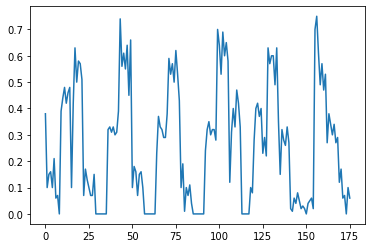

In [20]:
performancesMeasures.pk100.plot()